In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [44]:
class N_Armed_Bandit():
    
    def __init__(self,game,play,
                 n_arms,control_paras,
                 burning_period=1,
                 selection_method='softmax',
                 incre_implem=0):
        
        # times of game
        self.game = game
        
        # times of playround during each game
        self.play = play
        
        # how many levers
        self.n_arms = n_arms
        
        # epsilon for epsilon-greedy, tau(tempreture) for softmax
        self.control_paras = control_paras
        
        # how many rounds of burning period are included during the simulation
        self.burning_period = burning_period
        
        # n_unique of control_paras decisdes how many methods are competing
        self.n_group = len(control_paras)
        
        # which method to select action
        self.selection_method = selection_method
        
        # whether use incremental implementation
        self.incre_implem = incre_implem
        
    def __DataRestoration(self):
        
        # True rewards, fixed for each game
        self.true_rwd = np.random.normal(0,1,self.n_arms)
        self.best_action = np.argmax(self.true_rwd)
        
        # Estimated reward, update after each play
        self.estimated_rwd = np.zeros((self.n_group,self.n_arms))
        
        # Record total reward of each action, update after each play
        self.acc_action_rwd = np.zeros((self.n_group,self.n_arms))           
        
        # Track the times each action taken, used for update estimated reward when incre_implem=0, 
        # and for calculate optimal_choice%
        self.action_times = np.zeros((self.n_group,self.n_arms))
        
        # Track the optimal action taken percentage in each playround
        self.optimal_taken_percentage = np.zeros((self.n_group,self.play))

        # Track the accumulated reward during the play
        self.acc_rwd_track = np.zeros((self.n_group,self.play))   
        
        # Track the greedy action reward in each playround
        self.greedy_action_rwd_track = np.zeros((self.n_group,self.play))
        
    def Softmax_selection(self,Q_t):
        
        # reshape paras, to adapt numpy array computation
        tau = np.array(self.control_paras).reshape(self.n_group,-1)
        
        numerator = np.exp(Q_t/tau)
        denominator = numerator.sum(axis=1,keepdims=True)
        softmax_prob = numerator/denominator
        
        a=[]
        exploiting=[]
        
        for i in range(self.n_group):
                    
            a_temp = np.random.choice(list(range(self.n_arms)),p=softmax_prob[i,:])
            exploiting_temp = int(np.argmax(softmax_prob[i,:]))
            
            a.append(a_temp)
            exploiting.append(exploiting_temp)
            
        return a,exploiting
     
    def Epsilon_greedy_selection(self,Q_t):

        greedy_prob = np.random.uniform(0,1)
        a = []
        exploiting = []
        
        for i in range(self.n_group):

            if self.control_paras[i]==0:
                a_temp = int(np.argmax(self.estimated_rwd[i,:]))
                exploiting_temp = a_temp
                a.append(a_temp)
                exploiting.append(exploiting_temp)
            else:
                exploring = list(range(self.n_arms))
                exploiting_temp = np.argmax(self.estimated_rwd[i,:])
                exploring.remove(exploiting_temp)
                a_temp = int((greedy_prob<=self.control_paras[i])*np.random.choice(exploring))+int((greedy_prob>self.control_paras[i])*exploiting_temp)
                a.append(a_temp)
                exploiting.append(exploiting_temp)
                
        return a,exploiting
              
    def Choose_action(self,p):
        
        # Strategy During Burning Period
        if p < self.burning_period:
            
            a = np.random.randint(0,self.n_arms,self.n_group)
            exploiting = a
            
        # Strategy After Burning Period
        else:
            
            # Softmax Action Selection
            # ------------------------
            if self.selection_method=='softmax':
                
                a,exploiting = self.Softmax_selection(self.estimated_rwd)
                
            # Epsilon-Greedy Strategy 
            # ------------------------
            if self.selection_method=='epsilon':
                
                a,exploiting = self.Epsilon_greedy_selection(self.estimated_rwd)
                
        return a,exploiting
    
    def Update_Rewards(self,a,p,exploiting):
        
        for i in range(self.n_group):

            # update action times taken
            self.action_times[i,a[i]] += 1
            
            current_reward = np.random.normal(self.true_rwd[a[i]],1)
            
            if self.incre_implem==0:
                # update accumulated rewards of each action
                self.acc_action_rwd[i,a[i]] += current_reward

                # update estimated reward of each action
                self.estimated_rwd[i,a[i]] = self.acc_action_rwd[i,a[i]]/self.action_times[i,a[i]]
                
            if self.incre_implem==1:
                
                self.estimated_rwd[i,a[i]] = self.estimated_rwd[i,a[i]]/(p+1) + (current_reward-self.estimated_rwd[i,a[i]])/(p+1)
                
        # record the accumulated reward
        self.acc_rwd_track[:,p] = self.acc_action_rwd.sum(axis=1)/(p+1)
        
    def Track_Greedy(self,a,p,exploiting):
        
        for i in range(self.n_group):
            
            if p==0:
                # update optimal action reward
                self.greedy_action_rwd_track[i,p] = np.random.normal(self.true_rwd[exploiting[i]],1)
            else:
                self.greedy_action_rwd_track[i,p] = (p*(self.greedy_action_rwd_track[i,p-1])+np.random.normal(self.true_rwd[exploiting[i]],1))/(p+1) 
                
    def Track_Optimal(self,p):
        
        for i in range(self.n_group):
            
            self.optimal_taken_percentage[i,p] = self.action_times[i,self.best_action]/(p+1)
    
    def ReadyPlayer(self):
        
        # Track the accumulated reward after each game
        self.total_game_rwd_track = np.zeros((self.n_group,self.play))  
        
        # Track the accumulated reward after each game
        self.total_greedy_action_rwd_track = np.zeros((self.n_group,self.play)) 
        
        # Track the accumulated best action taken percentage after each game
        self.total_optimal_taken_percentage = np.zeros((self.n_group,self.play)) 
        
        for g in range(self.game):
            
            start = time.time()
            
            # each game need new data restoration
            self.__DataRestoration()
            
            for p in range(self.play):
                
                a,exploiting=self.Choose_action(p)
                self.Update_Rewards(a,p,exploiting)
                self.Track_Greedy(a,p,exploiting)
                self.Track_Optimal(p)
                
            self.total_game_rwd_track += self.acc_rwd_track  
            self.total_greedy_action_rwd_track += self.greedy_action_rwd_track
            self.total_optimal_taken_percentage += self.optimal_taken_percentage
            
            end = time.time()
            print('game{} finished, time cost {}seconds'.format(g,np.round(end-start,4)))
            
        self.total_game_rwd_track = self.total_game_rwd_track/self.game
        self.total_greedy_action_rwd_track = self.total_greedy_action_rwd_track/self.game
        self.total_optimal_taken_percentage = self.total_optimal_taken_percentage/self.game
        
        self.reward_data = pd.DataFrame(self.total_game_rwd_track[:,self.burning_period:]).T
        self.greedy_action = pd.DataFrame(self.total_greedy_action_rwd_track[:,self.burning_period:]).T
        self.optimal_taken = pd.DataFrame(self.total_optimal_taken_percentage[:,self.burning_period:]).T
        
        if self.selection_method=='softmax':
            self.reward_data.columns = ['tau='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['tau='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['tau='+str(i) for i in self.control_paras]
            
        if self.selection_method=='epsilon':
            self.reward_data.columns = ['epsilon='+str(i) for i in self.control_paras]
            self.greedy_action.columns = ['epsilon='+str(i) for i in self.control_paras]
            self.optimal_taken.columns = ['epsilon='+str(i) for i in self.control_paras]

In [45]:
# Epsilon-Greedy Strategy
RP1 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0,0.01,0.1,0.3,0.5],burning_period=1,
                     selection_method='epsilon',incre_implem=0)
# Softmax Strategy
RP2 = N_Armed_Bandit(game=50,play=4000,n_arms=10,
                     control_paras=[0.01,0.1,0.5,1,2],burning_period=1,
                     selection_method='softmax',incre_implem=0)

In [46]:
RP1.ReadyPlayer()

game0 finished, time cost 0.9187seconds
game1 finished, time cost 0.9189seconds
game2 finished, time cost 0.9567seconds
game3 finished, time cost 0.9428seconds
game4 finished, time cost 0.9444seconds
game5 finished, time cost 0.94seconds
game6 finished, time cost 0.9585seconds
game7 finished, time cost 0.9597seconds
game8 finished, time cost 0.9428seconds
game9 finished, time cost 0.9384seconds
game10 finished, time cost 0.9678seconds
game11 finished, time cost 0.9326seconds
game12 finished, time cost 0.9416seconds
game13 finished, time cost 0.9387seconds
game14 finished, time cost 0.9496seconds
game15 finished, time cost 0.9134seconds
game16 finished, time cost 0.9269seconds
game17 finished, time cost 0.9521seconds
game18 finished, time cost 0.9321seconds
game19 finished, time cost 0.9492seconds
game20 finished, time cost 0.959seconds
game21 finished, time cost 0.9599seconds
game22 finished, time cost 0.9647seconds
game23 finished, time cost 0.9393seconds
game24 finished, time cost 0.

In [50]:
RP2.ReadyPlayer()

game0 finished, time cost 1.6024seconds
game1 finished, time cost 1.6423seconds
game2 finished, time cost 1.3981seconds
game3 finished, time cost 1.5001seconds
game4 finished, time cost 1.312seconds
game5 finished, time cost 1.5275seconds
game6 finished, time cost 1.4843seconds
game7 finished, time cost 1.2819seconds
game8 finished, time cost 1.3065seconds
game9 finished, time cost 1.5214seconds
game10 finished, time cost 1.4358seconds
game11 finished, time cost 1.4726seconds
game12 finished, time cost 1.5425seconds
game13 finished, time cost 1.5612seconds
game14 finished, time cost 1.2691seconds
game15 finished, time cost 1.3016seconds
game16 finished, time cost 1.6017seconds
game17 finished, time cost 1.3359seconds
game18 finished, time cost 1.3888seconds
game19 finished, time cost 1.3584seconds
game20 finished, time cost 1.3102seconds
game21 finished, time cost 1.3319seconds
game22 finished, time cost 1.3623seconds
game23 finished, time cost 1.5745seconds
game24 finished, time cost 

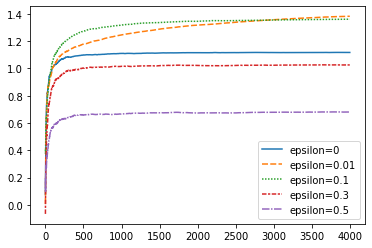

In [47]:
# Epsilon-greedy strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure()
sns.lineplot(data = RP1.reward_data)

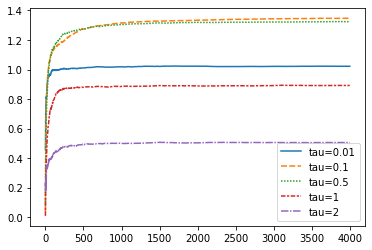

In [51]:
# Softmax strategy, total average rewards after 50 games with 4000 playing rounds for each
plt.figure()
sns.lineplot(data = RP2.reward_data)

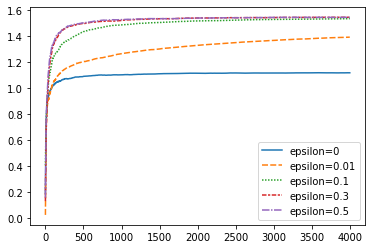

In [48]:
# Epsilon-greedy strategy, total average rewards under greedy action selection
plt.figure()
sns.lineplot(data = RP1.greedy_action)

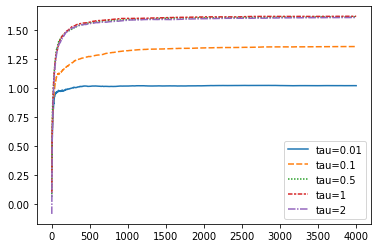

In [53]:
# Softmax strategy, total average rewards under greedy action selection
plt.figure()
sns.lineplot(data = RP2.greedy_action)

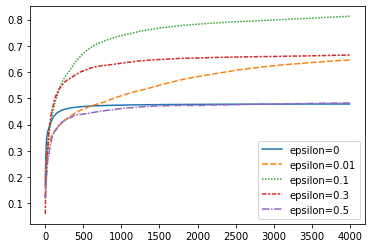

In [49]:
# Epsilon-greedy strategy, optimal actions taken percentage
plt.figure()
sns.lineplot(data = RP1.optimal_taken)

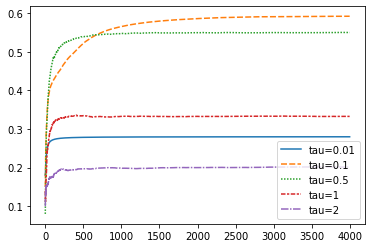

In [54]:
# Softmax strategy, optimal actions taken percentage
plt.figure()
sns.lineplot(data = RP2.optimal_taken)